In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [187]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 해야할 것
- 모델 튜닝 끝내서 저장시켜놓기(rmse 최소화)
- 1번째 값부터 148168번째 값까지 예측 완료하여 csv로 저장하기
  + 이거 수정사항 있음: 미래 예측 각을 하나로만 살리고 있는데 이거 수정할지말지
- 원래 디비 수정하기
  + 스마트팜 작동변수 갈아 끼우기
    * 작동변수 고도화(23, 25,,,)
  + 더미화해서 내부온도 예측했던거 다시 원래대로 돌려놓기
  + 이거 위에서 한 번에 하는 걸로!

In [188]:
df=pd.read_csv("/content/drive/MyDrive/Smart Farm/Data/concat_df.csv").drop(['Unnamed: 0'], axis=1)
df.shape

(18720, 54)

In [189]:
max(df['천창'])

4.61512051684126

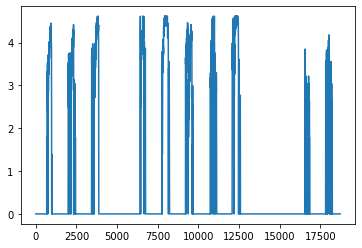

In [190]:
plt.plot(df['천창'])

In [191]:
yhat_arr=np.load('/content/drive/MyDrive/Smart Farm/Data/yhat_arr.npy')
len(yhat_arr)

18719

In [192]:
df.columns

Index(['차열스크린_온도조절_23도미만', '난방온도(설정온도)', '외기온(℃)', '일사량(W/㎡)',
       '차열스크린_온도조절_23도~25도', '환기온도(천창 제어온도)_27', '에너지스크린(수직)', '내부 습도',
       '차열스크린_개방조절_100%개방', '차열스크린_온도조절_25도~26도', '시간범주_야간', '일출1시간후', '배기팬_1',
       '일몰전후_일몰1시간반_전', '에너지스크린(수평)', '일몰3시간후', '시간범주_그외', '팬코일 B동_0.0',
       '일몰1시간반전', 'PM10등급_좋음', '차광스크린(수평)', 'PM25_1시간', 'PM10_1시간', '누적강수량',
       '해면기압', '현지기압', '차광스크린_개방_0', '천창', 'PM25등급_보통', '아황산가스_1시간', '지면온도',
       '오존_1시간', '이산화질소_1시간', '오존등급_보통', '일조', '풍속(m/s)', '환기온도(천창 제어온도)_28',
       '년도', 'PM10등급_나쁨', '일산화탄소_1시간', '풍향(º)', '외기습도(%)', '이산화질소등급_나쁨',
       '유동팬_0', '아황산가스등급_보통', '차열스크린_개방조절_0%~30%개방', '하루길이',
       '차광스크린_개방조절_80%~100%개방', 'PM25등급_좋음', '일출일몰_일출', '차열스크린(수평)',
       '차열스크린_개방조절_30%~70%개방', 'const', '내부 온도'],
      dtype='object')

In [193]:
#data = pd.read_csv("smart_farm_final.csv").sample(n = 50000)
org_data = pd.read_csv("/content/drive/MyDrive/Smart Farm/Data/smart_farm_final.csv")
org_data.shape

(148168, 57)

In [194]:
len(org_data['배기팬'][129449:]) # 129448 아닌 이유: val set 중 첫 번째는 데이터 넣느라 예측한 결과물에 포함 안 됨!

18719

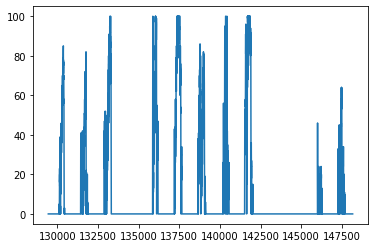

In [195]:
plt.plot(org_data['천창'][129449:])
plt.show()

In [196]:
org_data.columns

Index(['시간', '년도', '월', '일', '시', '분', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)',
       '풍속(m/s)', '풍향(º)', '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)',
       '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창', '유동팬', '팬코일 B동',
       '환기온도(천창 제어온도)', '난방온도(설정온도)', '열공급량(kWh)', '누적강수량', '현지기압', '해면기압',
       '일조', '년월일', 'PM10_1시간', 'PM25_1시간', '오존_1시간', '이산화질소_1시간', '일산화탄소_1시간',
       '아황산가스_1시간', '차광스크린_개방', '차광스크린_광도조절', '차광스크린_개방조절', '차열스크린_온도조절',
       '차열스크린_광도조절', '차열스크린_개방조절', '일출시간', '일몰시간', '일출3시간후', '일출1시간후',
       '일몰3시간후', '일몰1시간반전', '하루길이', '시간범주', '일몰전후', '일출일몰', '지면온도', '오존등급',
       '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급'],
      dtype='object')

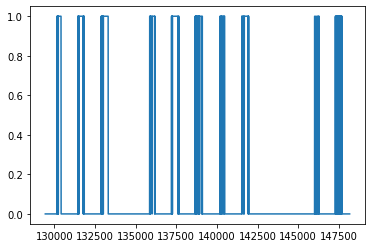

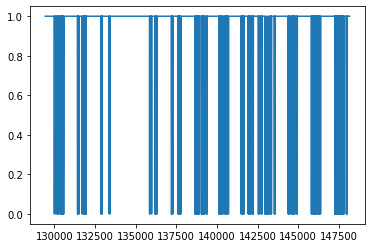

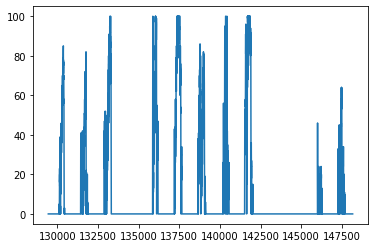

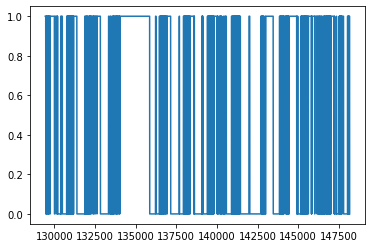

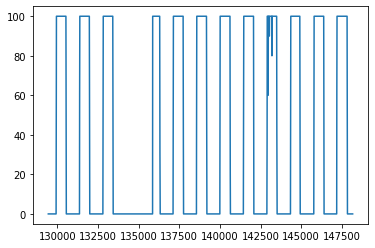

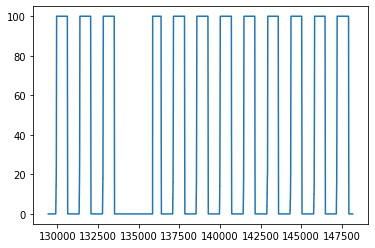

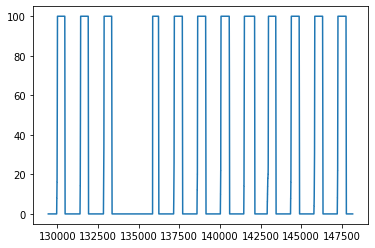

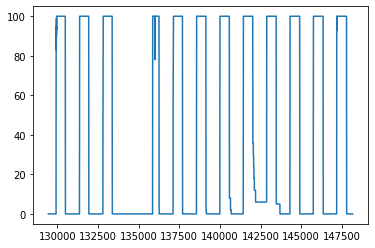

In [197]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129449:])
  plt.show()

In [198]:
org_data['배기팬'][129449:]=-1
org_data['유동팬'][129449:]=-1
org_data['팬코일 B동'][129449:]=-1
org_data['천창'][129449:]=-1
org_data['에너지스크린(수평)'][129449:]=-1
org_data['에너지스크린(수직)'][129449:]=-1
org_data['차광스크린(수평)'][129449:]=-1
org_data['차열스크린(수평)'][129449:]=-1

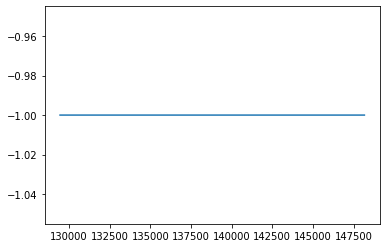

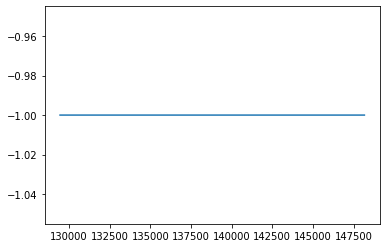

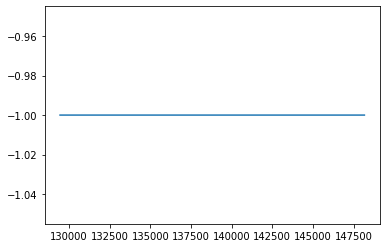

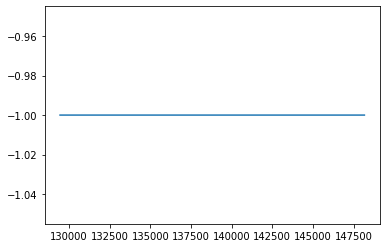

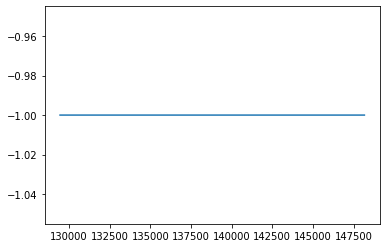

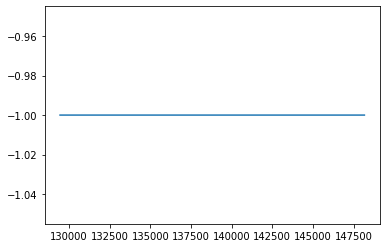

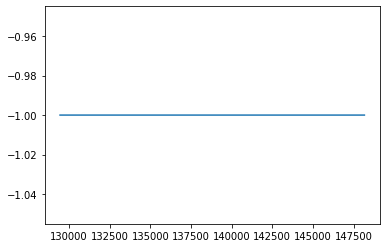

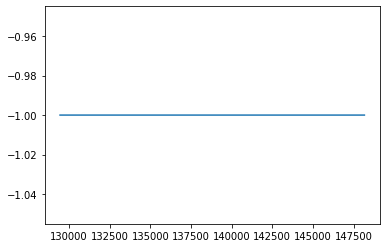

In [199]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129449:])
  plt.show()

In [200]:
# '배기팬_1','유동팬_0','천창','팬코일 B동_0.0','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)'

for i in range(len(df)):
  org_data['내부 온도'][129449+i]=df['내부 온도'][i]
  if df['배기팬_1'][i]==1: org_data['배기팬'][129449+i]=1
  else: org_data['배기팬'][129449+i]=0
  if df['유동팬_0'][i]==1: org_data['유동팬'][129449+i]=0
  else: org_data['유동팬'][129449+i]=1
  if df['팬코일 B동_0.0'][i]==1: org_data['팬코일 B동'][129449+i]=0.0
  else: org_data['팬코일 B동'][129449+i]=1.0

  # 100이 없음..!?!
  if df['천창'][i]==100: org_data['천창'][129449+i]=100
  else: org_data['천창'][129449+i]=0

  ## 하위 네 개는 연속적인 값을 띔. 100과 0 사이에 연속적인 증감 구간이 필요할 것 같음
  if df['에너지스크린(수평)'][i]==100: org_data['에너지스크린(수평)'][129449+i]=100
  else: org_data['에너지스크린(수평)'][129449+i]=0
  if df['에너지스크린(수직)'][i]==100: org_data['에너지스크린(수직)'][129449+i]=100
  else: org_data['에너지스크린(수직)'][129449+i]=0
  if df['차광스크린(수평)'][i]==100: org_data['차광스크린(수평)'][129449+i]=100
  else: org_data['차광스크린(수평)'][129449+i]=0
  if df['차열스크린(수평)'][i]==100: org_data['차열스크린(수평)'][129449+i]=100
  else: org_data['차열스크린(수평)'][129449+i]=0

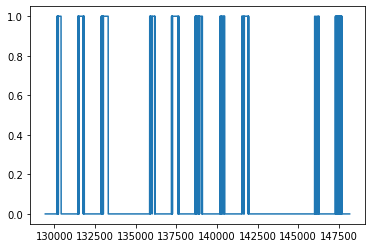

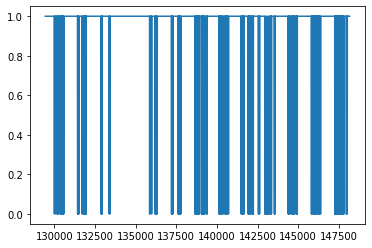

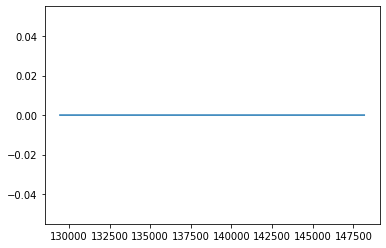

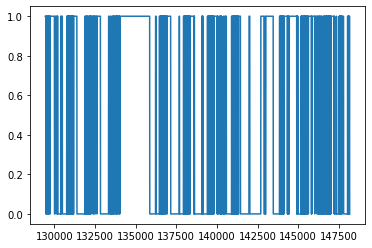

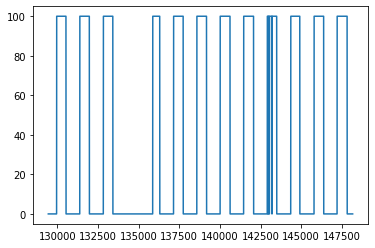

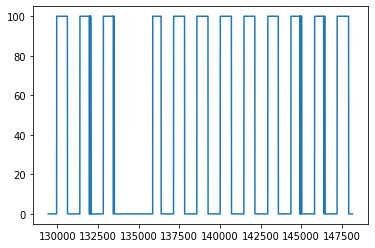

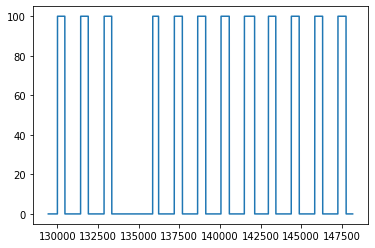

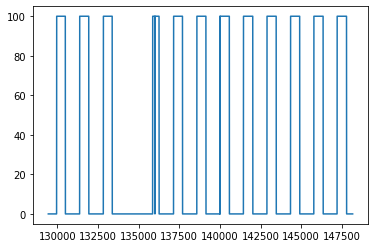

In [201]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129448:])
  plt.show()

In [202]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  print(org_data[col][:129448].value_counts()) # 천창과 스크린들

0    119542
1      9906
Name: 배기팬, dtype: int64
1    124451
0      4997
Name: 유동팬, dtype: int64
0     112405
3        786
4        674
5        580
7        552
       ...  
93        16
96        13
97        13
99         8
98         5
Name: 천창, Length: 101, dtype: int64
1.0    84489
0.0    44959
Name: 팬코일 B동, dtype: int64
0      80730
100    45388
90       183
70       142
80       141
       ...  
46        19
25        18
66        18
41        18
88        17
Name: 차광스크린(수평), Length: 101, dtype: int64
0      71883
100    52458
2        300
4        284
6        278
       ...  
64        19
46        15
53        15
17        15
82        14
Name: 차열스크린(수평), Length: 101, dtype: int64
0      92245
100    32576
2        246
4        231
6        230
       ...  
28        17
78        16
85        15
71        13
42        10
Name: 에너지스크린(수평), Length: 101, dtype: int64
0      86948
100    41027
93        64
90        60
57        56
       ...  
9          3
2          2
29       

### 각도 조절(천창, 스크린들)
- 각 창별 극대, 극소 구간에 대한 평균 변화량을 구해서
- 그 각도로 변동을 조절해야할듯

In [203]:
delta_avgs={}
deltas={}

for col in ['천창', '차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  minmax_idx=[]
  # 극대/극소 구하기
  for i in range(1, 129448-1):
    # org_data[i]가 극소: 경계에 같은거 하나 있는거 포함
    if (org_data[col][i-1]>org_data[col][i] and org_data[col][i+1]>=org_data[col][i]) or (org_data[col][i-1]>=org_data[col][i] and org_data[col][i+1]>org_data[col][i]):
      minmax_idx.append(i)
    # org_data[i]가 극대
    elif (org_data[col][i-1]<org_data[col][i] and org_data[col][i+1]<=org_data[col][i]) or (org_data[col][i-1]<=org_data[col][i] and org_data[col][i+1]<org_data[col][i]):
      minmax_idx.append(i)
  # 극대 극소 별 변화량 평균 구하기
  delta=[]
  for i in range(1, len(minmax_idx)):
    # 변화량의 절대값을 넷째자리에서 반올림
    delta_tmp=round(abs((org_data[col][minmax_idx[i]]-org_data[col][minmax_idx[i-1]])/(minmax_idx[i]-minmax_idx[i-1])), 3)
    if delta_tmp>2.0: # 변화량 2보다 작은거
      delta.append(delta_tmp)
  delta.sort()
  #delta=delta[int(len(delta)*2/3):] # 앞에 2/3 삭제
  delta_avgs[col]=np.mean(delta)
  deltas[col]=delta
delta_avgs

{'에너지스크린(수직)': 12.814032258064515,
 '에너지스크린(수평)': 6.868593582887701,
 '차광스크린(수평)': 5.471212938005391,
 '차열스크린(수평)': 6.781317204301075,
 '천창': 4.956950971786834}

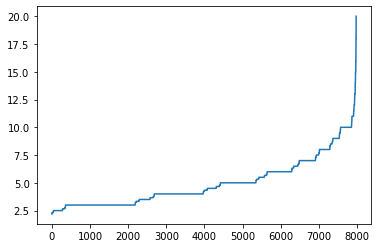

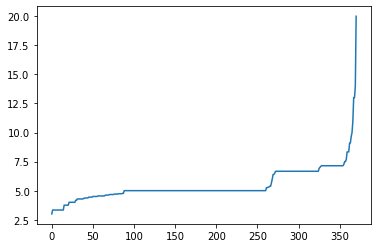

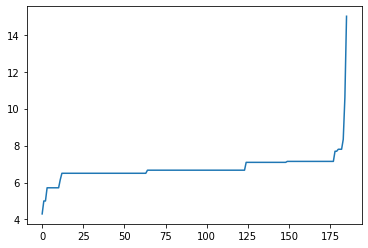

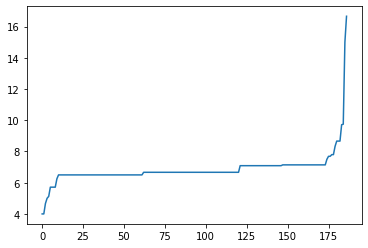

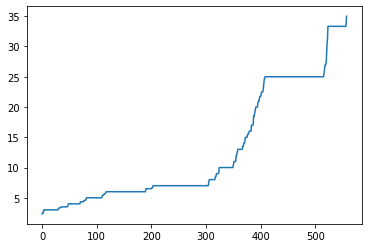

In [204]:
for col in ['천창', '차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(deltas[col])
  plt.show()

In [205]:
for col in ['천창', '차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']: #delta_avgs
  for i in range(len(df)-1):
    if org_data[col][129448+i+1]==0: # 감소
      org_data[col][129448+i+1]=org_data[col][129448+i]-delta_avgs[col]
    elif org_data[col][129448+i+1]==100: # 증가
      org_data[col][129448+i+1]=org_data[col][129448+i]+delta_avgs[col]
    
    # 0 ~ 100 유지
    if org_data[col][129448+i+1]>100: org_data[col][129448+i+1]=100
    if org_data[col][129448+i+1]<0: org_data[col][129448+i+1]=0



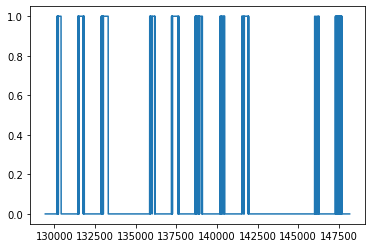

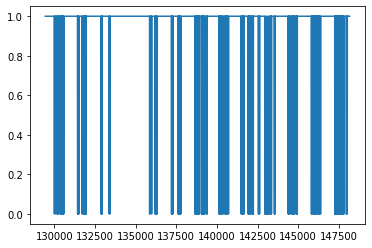

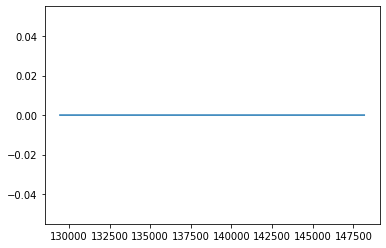

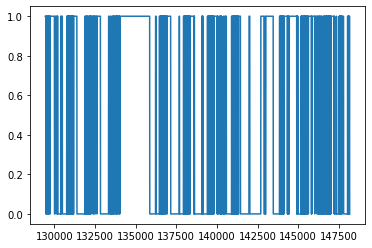

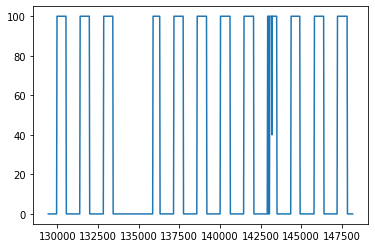

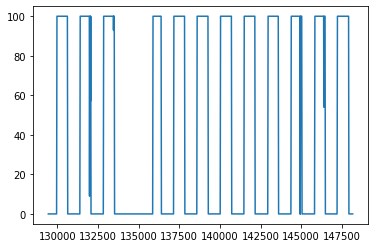

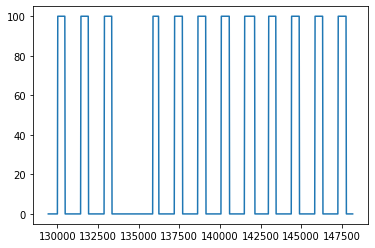

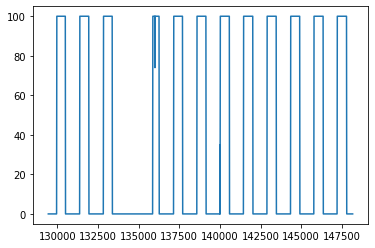

In [206]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129448:])
  plt.show()

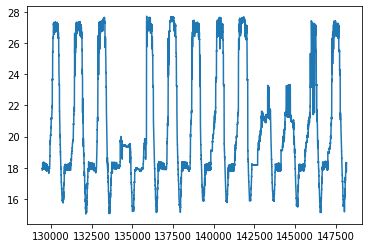

In [207]:
plt.plot(org_data['내부 온도'][129448:])

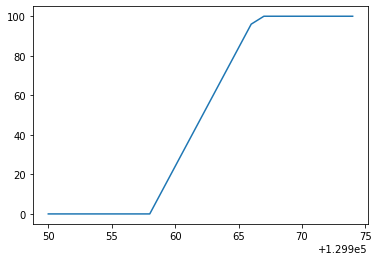

In [226]:
plt.plot(org_data['에너지스크린(수직)'][129950:129975])

# 기존

In [208]:
data = org_data.drop(["시간","분","년월일"],axis=1)
data.drop(["차열스크린_광도조절","차광스크린_광도조절"],axis=1,inplace=True)

In [209]:
data["팬코일 B동"] = data["팬코일 B동"].apply(lambda x : 1 if x == 0.5 else x )

In [210]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

문자열 칼럼 추출

In [211]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [212]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ['배기팬','유동팬','팬코일 B동', "차광스크린_개방","열공급량(kWh)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동', "차광스크린_개방"]

object_no_binary = object_lst.copy()

In [213]:
data["차광스크린_개방"].value_counts()

0    134934
1     13234
Name: 차광스크린_개방, dtype: int64

In [214]:
object_no_binary

['차광스크린_개방조절',
 '차열스크린_온도조절',
 '차열스크린_개방조절',
 '시간범주',
 '일몰전후',
 '일출일몰',
 '오존등급',
 '아황산가스등급',
 '이산화질소등급',
 'PM10등급',
 'PM25등급']

In [215]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [216]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도','환기온도(천창 제어온도)']:
    
    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

In [217]:
for col in ["일조","년도","월",'일출시간', '일몰시간', '일출3시간후',
       '일출1시간후', '일몰3시간후', '일몰1시간반전', '하루길이']:
    
    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[col].values.reshape(-1,1))
    data[col] = data_scaled

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

In [218]:
data_scaled = data.copy()

In [219]:
object_lst_real

['차광스크린_개방조절',
 '차열스크린_온도조절',
 '차열스크린_개방조절',
 '시간범주',
 '일몰전후',
 '일출일몰',
 '오존등급',
 '아황산가스등급',
 '이산화질소등급',
 'PM10등급',
 'PM25등급',
 '배기팬',
 '유동팬',
 '팬코일 B동',
 '차광스크린_개방']

In [220]:
Y = data_scaled["열공급량(kWh)"]

X_dummy = pd.get_dummies(data_scaled.drop(["열공급량(kWh)"],axis=1)
                         ,columns = object_lst + ["일","시"])

In [221]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

In [222]:
data_scaled_final.to_csv("/content/drive/MyDrive/Smart Farm/Data/smart_farm_final_scaled_ver1.csv",encoding="utf-8-sig",index=False)

In [223]:
data_scaled_final # (148168 rows × 103 columns) -> 126인듯

,년도,월,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),...,시_15,시_16,시_17,시_18,시_19,시_20,시_21,시_22,시_23,열공급량(kWh)
0,0.0,0.909091,0.0,0.495238,0.643678,0.000000,0.901408,0.447257,0.485804,0.0,...,0,0,0,0,0,0,0,0,0,0.9
1,0.0,0.909091,0.0,0.495238,0.643678,0.024242,0.954930,0.438819,0.507886,0.0,...,0,0,0,0,0,0,0,0,0,0.9
2,0.0,0.909091,0.0,0.492063,0.643678,0.054545,0.281690,0.421941,0.536278,0.0,...,0,0,0,0,0,0,0,0,0,0.9
3,0.0,0.909091,0.0,0.492063,0.643678,0.078788,0.332394,0.421941,0.515773,0.0,...,0,0,0,0,0,0,0,0,0,0.8
4,0.0,0.909091,0.0,0.492063,0.643678,0.054545,0.332394,0.417722,0.528391,0.0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148163,1.0,0.181818,0.0,0.507937,0.574713,0.024242,0.954930,0.448228,0.669558,0.0,...,0,0,0,0,0,0,0,0,1,NaN
148164,1.0,0.181818,0.0,0.507937,0.574713,0.000000,0.954930,0.448608,0.657098,0.0,...,0,0,0,0,0,0,0,0,1,NaN
148165,1.0,0.181818,0.0,0.504762,0.574713,0.024242,0.954930,0.447342,0.676498,0.0,...,0,0,0,0,0,0,0,0,1,NaN
148166,1.0,0.181818,0.0,0.504762,0.574713,0.024242,0.960563,0.448186,0.669716,0.0,...,0,0,0,0,0,0,0,0,1,NaN
